# Code for 8-puzzle AI Solver
---
## Code

### Dependencies

In [1]:
import numpy as np
from queue import PriorityQueue
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import unittest
from tqdm import tqdm_notebook

# refresh font cache
mpl.font_manager._rebuild()

# plot style options
plt.rcParams['font.family'] = 'Myriad Pro'
plt.rcParams['font.weight'] = 'light'
plt.rcParams['axes.labelweight'] = 'light'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.bottom'] = False 
plt.rcParams['ytick.left'] = False 

%matplotlib inline

### Puzzle Class

In [2]:
class PuzzleNode():
    '''
    PuzzleNode class for node states and state bookkeeping
    '''
    def __init__(self, heuristic, state, g, last_move, parent):
        # convert state to numpy array if list
        if type(state) == list:
            state = np.array(state)
            
        self.size = state.shape[0] # node state dimension size
        self.state = state.astype(int)  # set PuzzleNode state
        self.gap_position = [i[0] for i in np.where(self.state == 0)]  # position of gap in node state
        self.g = g # g(n) cost
        self.cost = g + heuristic(self.state) # f(n) = g(n) + h(n)
        self.last_move = last_move # move needed to get to node state
        self.parent = parent # parent state of node state
    
    def move_choice(self):
        '''
        Return list of allowable moves
        '''
        not_permitted = {'right':'left', 'up':'down', 'left':'right', 'down':'up'}
        possible_moves = set()
        x, y = self.gap_position
        
        if 0 < x < (self.size-1):
            possible_moves.add("up")
            possible_moves.add("down")
        elif x == 0:
            possible_moves.add("up")
        else:
            possible_moves.add("down")
            
        if 0 < y < (self.size-1):
            possible_moves.add("left")
            possible_moves.add("right")
        elif y == 0:
            possible_moves.add("left")
        else:
            possible_moves.add("right")
        
        # remove undo move from allowable moves
        undo_move = set()
        undo_move.add(not_permitted[self.last_move]) if self.last_move is not None else None
        possible_moves = possible_moves - undo_move
        
        return list(possible_moves)
    
    def move(self, move):
        '''
        Move puzzle given allowable move
        '''
        # copy puzzle state to prevent corruption
        new_state = self.state.copy()
        x, y = self.gap_position 
        
        # slide left
        if move == "left":
            new_state[x, y] = self.state[x, y+1]
            new_state[x, y+1] = self.state[x, y]
        # slide right
        if move == "right":
            new_state[x, y] = self.state[x, y-1]
            new_state[x, y-1] = self.state[x, y]
        # slide up
        if move == "up":
            new_state[x, y] = self.state[x+1, y]
            new_state[x+1, y] = self.state[x, y]
        # slide down
        if move == "down":
            new_state[x, y] = self.state[x-1, y]
            new_state[x-1, y] = self.state[x, y]
        
        # return new state after move is made
        return new_state.astype(int)
    
    def __str__(self):
        '''
        Print out the current puzzle state
        '''
        return str(self.state)

### Supporting functions

In [3]:
########################################
# Heuristics
########################################

class heuristic_memoization(dict):
    '''
    Memoization class decorator that feeds pre-computed
    heuristic values if available
    '''
    def __init__(self, func):
        self.func = func
        
    def __call__(self, *args):
        state = args[0]
        heuristic_name = self.func.__name__
        
        # check if dictionary for heuristic exists
        if heuristic_name not in self:
            self[heuristic_name] = {}
            
        state_key = pickle.dumps(state)
        if state_key in self[heuristic_name]: # check if state is memoized
            h_val = self[heuristic_name][state_key]
        else: # else save to memoization dictionary
            h_val = self.func(state)
            self[heuristic_name][state_key] = h_val
        
        return h_val
    
@heuristic_memoization
def h1(state):
    '''
    Heuristic function for number of misplaced tiles
    '''
    # count the number of correctly placed tiles
    n = state.shape[0]
    goal_state = np.array([[int(i*n+j) for j in range(n)] for i in range(n)])
    correct = np.sum(goal_state == np.array(state))
    
    # return number of incorrectly placed tiles
    return n**2-correct

@heuristic_memoization
def h2(state):
    '''
    Heuristic function for Manhattan distance
    The sum of manhattan distances of all tiles from their
    goal state
    '''
    n = state.shape[0]
    goal_state = np.array([[int(i*n+j) for j in range(n)] for i in range(n)])
    
    manhattan_distance = 0
    
    # calculate manhattan distance between every goal state and current state
    for i in np.arange(1, n**2):
        x1, y1 = np.where(goal_state == i)
        x2, y2 = np.where(state == i)
        
        manhattan_distance += (abs(x2[0]-x1[0]) + abs(y2[0]-y1[0]))
        
    return manhattan_distance

########################################
# Other functions for solvePuzzle
########################################

def puzzleCheck(n, state):
    '''
    Check input state is valid
    '''
    # convert state to numpy array if list
    if type(state) == list:
        state = np.array(state)
    
    # check shape is correct and all numbers are represented in state array
    if (state.shape == (n,n)) and (list(set(state.flatten())) == list(np.arange(0, n**2))):
        return True
    
    return False

def retrieve_solution(explored, goal_state):
    '''
    Retrieves the solution path from the explored dictionary by iterating 
    from the goal state to the start state through the puzzleNodes
    ''' 
    # create solution array starting with goal state
    solution = [(goal_state, None)]
    current_state_key = pickle.dumps(goal_state)
    
    while True:
        last_move = explored[current_state_key].last_move
        previous_state = explored[current_state_key].parent
        if pickle.dumps(explored[current_state_key].parent) == pickle.dumps(None):
            break
        else:
            solution.append((previous_state, last_move))
            current_state_key = pickle.dumps(explored[current_state_key].parent)
        
    return len(solution)-1, solution[::-1]

### A* Search Function

In [4]:
def solvePuzzle(n, state, heuristic, prnt):
    '''
    A* Search function given heuristic
    INPUT:
    n - puzzle dimension
    state - starting puzzle state
    heuristic - the heuristic to use for A* search
    prnt - whether or not to print solution
    
    OUTPUT:
    steps - number of steps to optimally reach goal
    frontierSize - worst-case frontier size during search
    err - error code
    '''
    # default values for output
    steps = 0
    frontierSize = 0
    err = 0
    
    # keep track of goal state
    goal_state = np.array([[int(i*n+j) for j in range(n)] for i in range(n)]) # goal state of puzzle
    
    # initialise frontier
    frontier = PriorityQueue()
    # initialise list of explored node objects
    explored = {}
    
    # check start state is valid
    if puzzleCheck(n, state)==False:
        return steps, frontierSize, -1
    
    # initialise starting puzzleNode object 
    g = 0
    last_move = None
    parent = None
    start_node = PuzzleNode(heuristic, state, g, last_move, parent)
    
    # pickle states to use as dict key in explored
    start_state_key = pickle.dumps(start_node.state) 
    
    # add starting node to explored states
    explored[start_state_key] = start_node
    # add first object to frontier
    frontier.put((start_node.cost, start_state_key))
    
    # loop over frontier while it's not empty
    while not frontier.empty():
        # retrieve and remove state with lowest cost from frontier
        _, current_state_key = frontier.get()
        
        # retrieve current node state
        current_node = explored[current_state_key]
        
        # check if goal has been reached
        if np.all(current_node.state == goal_state):
            break
        
        # get allowable moves from node
        moves = current_node.move_choice()
        
        # iterate over permissible next moves
        for move in moves:
            # get new state after move 
            new_state = current_node.move(move)
            new_state_key = pickle.dumps(new_state)
            
            # create new node from state
            g = current_node.g + 1
            parent = current_node.state
            new_node = PuzzleNode(heuristic, new_state, g, move, parent)
            
            # get cost of new state from created node
            new_state_cost = new_node.cost
            
            # get previous cost if state was already explored
            prev_explored_cost = explored.get(new_state_key).cost if explored.get(new_state_key) is not None else 0
                        
            # check if state hasn't been explored or if the current expansion would be
            # cheaper than when previously expanded
            if new_state_key not in explored.keys() or new_state_cost < prev_explored_cost:
                # if so add/update frontier and explored states
                explored[new_state_key] = new_node
                frontier.put((new_state_cost, new_state_key))
        
        # update frontier size if larger than previous largest size
        if len(frontier.queue) > frontierSize:
            frontierSize = len(frontier.queue)
    
    # retrieve solution by backtracking through explored states
    steps, solution = retrieve_solution(explored, goal_state)
    
    # print out solution if option is set in function
    if prnt == True or prnt == 1:
        print("Solution steps: \n")
        for ind, s in enumerate(solution):
            if s[1] != None:
                print(s[0],"\n")
                print("Move %d: %s\n"%(ind+1, s[1]))
            else:
                print(s[0],"\n")
                print("Solved \n")
                
        print("Number of steps to reach goal: %d \n"%steps)
        print("Maximum frontier size: %d"%frontierSize)
    
    return steps, frontierSize, err

### Unit Tests
Run unit tests to check functionality of code works as expected

In [21]:
class TestNotebook(unittest.TestCase):
    '''
    Function to test PuzzleNode class
    functionality
    '''
    def test_dimension(self):
        '''
        Check if puzzles of different sizes
        are created correctly
        '''
        dims = []
        for n in [2,3,6,12]:
            state = np.zeros((n,n)).astype(int)
            g = 0
            last_move = None
            parent = None
            node = PuzzleNode(h1, state, g, last_move, parent)
            dims.append((node.state.shape))
            
        self.assertEqual(dims, [(2,2),(3,3),(6,6),(12,12)])
        
    def test_gap_position(self):
        '''
        Check if gap position is correct
        for custom state setting
        '''
        state = [[1,1,1],[1,0,1],[1,1,1]]
        g = 0
        last_move = None
        parent = None
        node = PuzzleNode(h1, state, g, last_move, parent)
        gap_position = node.gap_position 
        
        self.assertEqual(gap_position, [1,1])
        
    def test_move_choice_one(self):
        '''
        Check if move_choice function works as expected
        '''
        state = [[1,1,1],[1,1,1],[1,1,0]]
        g = 0
        last_move = None
        parent = None
        node = PuzzleNode(h1, state, g, last_move, parent)
        
        self.assertEqual(set(node.move_choice()) == set(['right', 'down']), 1)
        
    def test_move_choice_two(self):
        '''
        Check if move_choice function works as expected
        '''
        state = [[1,0,1],[1,1,1],[1,1,1]]
        g = 0
        last_move = None
        parent = None
        node = PuzzleNode(h1, state, g, last_move, parent)
        
        self.assertEqual(set(node.move_choice()) == set(['left', 'right', 'up']), 1)
        
    def test_move_choice_three(self):
        '''
        Check if move_choice function works as expected
        '''
        state = [[1,0,1],[1,1,1],[1,1,1]]
        g = 0
        last_move = "left"
        parent = None
        node = PuzzleNode(h1, state, g, last_move, parent)
        
        self.assertEqual(set(node.move_choice()) == set(['left', 'up']), 1)
    
    def test_move_left(self):
        '''
        Check if move left function works as expected
        '''
        state = [[1, 0, 2],[3, 4, 5],[6, 7, 8]]
        g = 0
        last_move = None
        parent = None
        node = PuzzleNode(h1, state, g, last_move, parent)
        new_state = node.move('left')
        
        expected_new = [[1, 2, 0],[3, 4, 5],[6, 7, 8]]
        
        self.assertEqual(np.all(new_state == expected_new), 1)
        
    def test_move_right(self):
        '''
        Check if move right function works as expected
        '''
        state = [[1,1,1],[1,1,1],[1,1,0]]
        g = 0
        last_move = None
        parent = None
        node = PuzzleNode(h1, state, g, last_move, parent)
        new_state = node.move('right')
        
        expected_new = [[1,1,1],[1,1,1],[1,0,1]]
        
        self.assertEqual(np.all(new_state == expected_new), 1)
        
    def test_move_down(self):
        '''
        Check if move down function works as expected
        '''
        state = [[1,1,1],[1,0,1],[1,1,1]]
        g = 0
        last_move = None
        parent = None
        node = PuzzleNode(h1, state, g, last_move, parent)
        new_state = node.move('down')
        
        expected_new = [[1,0,1],[1,1,1],[1,1,1]]
        
        self.assertEqual(np.all(new_state == expected_new), 1)
        
    def test_move_up(self):
        '''
        Check if move up function works as expected
        '''
        state = [[1,1,1],[1,0,1],[1,1,1]]
        g = 0
        last_move = None
        parent = None
        node = PuzzleNode(h1, state, g, last_move, parent)
        new_state = node.move('up')
        
        expected_new = [[1,1,1],[1,1,1],[1,0,1]]
        
        self.assertEqual(np.all(new_state == expected_new), 1)
        
    def test_misplaced_tiles_one(self):
        '''
        Check misplaced tiles heuristic works correctly
        '''
        state = np.array([[0,1,2],[3,4,5],[6,7,8]])
        val = h1(state)
        
        self.assertEqual(val, 0)
        
    def test_misplaced_tiles_two(self):
        '''
        Check misplaced tiles heuristic works correctly
        '''
        state = np.array([[1,2,0],[4,3,5],[6,8,7]])
        val = h1(state)
        
        self.assertEqual(val, 7)
    
    def test_manhattan_distance_one(self):
        '''
        Check manhattan distance heuristic works correctly
        '''
        state = np.array([[0,1,2],[3,4,5],[6,7,8]])
        val = h2(state)
        
        self.assertEqual(val, 0)
        
    def test_manhattan_distance_two(self):
        '''
        Check manhattan distance heuristic works correctly
        '''
        state = np.array([[1,0,2],[3,4,5],[6,7,8]])
        val = h2(state)
        
        self.assertEqual(val, 1)
        
    def test_manhattan_distance_three(self):
        '''
        Check manhattan distance heuristic works correctly
        '''
        state = np.array([[2,1,0],[3,5,4],[6,8,7]])
        val = h2(state)
        
        self.assertEqual(val, 6)
        
    def test_solve_puzzle_one(self):
        '''
        Check incorrect puzzles are not accepted
        '''
        res = solvePuzzle(3, [[0,0,0],[0,0,0],[0,0,0]], h1, 0)
        
        self.assertEqual(res, (0,0,-1))
        
    def test_solve_puzzle_two(self):
        '''
        Check incorrect puzzles are not accepted
        '''
        res = solvePuzzle(3, [[0,1,2],[3,4,5],[6,6,8]], h1, 0)
        
        self.assertEqual(res, (0,0,-1))
        
    def test_solve_puzzle_three(self):
        '''
        Check incorrect puzzles are not accepted
        '''
        res = solvePuzzle(3, [[1,0,2],[3,4,5],[6,7,8]], h1, 0)
        
        self.assertEqual(res, (1,3,0))

unittest.main(argv=[''], verbosity=2, exit=False)

test_dimension (__main__.TestNotebook) ... ok
test_gap_position (__main__.TestNotebook) ... ok
test_manhattan_distance_one (__main__.TestNotebook) ... ok
test_manhattan_distance_three (__main__.TestNotebook) ... ok
test_manhattan_distance_two (__main__.TestNotebook) ... ok
test_misplaced_tiles_one (__main__.TestNotebook) ... ok
test_misplaced_tiles_two (__main__.TestNotebook) ... ok
test_move_choice_one (__main__.TestNotebook) ... ok
test_move_choice_three (__main__.TestNotebook) ... ok
test_move_choice_two (__main__.TestNotebook) ... ok
test_move_down (__main__.TestNotebook) ... ok
test_move_left (__main__.TestNotebook) ... ok
test_move_right (__main__.TestNotebook) ... ok
test_move_up (__main__.TestNotebook) ... ok
test_solve_puzzle_one (__main__.TestNotebook) ... ok
test_solve_puzzle_three (__main__.TestNotebook) ... ok
test_solve_puzzle_two (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 17 tests in 0.046s

OK


---
## Run A* search on scrambled boards

### Trial run with solution

In [22]:
steps, frontierSize, err = solvePuzzle(4, [[1,2,6,3],[4,5,10,7],[8,13,9,11],[12,14,15,0]], h2, 1)

Solution steps: 

[[ 1  2  6  3]
 [ 4  5 10  7]
 [ 8 13  9 11]
 [12 14 15  0]] 

Move 1: right

[[ 1  2  6  3]
 [ 4  5 10  7]
 [ 8 13  9 11]
 [12 14  0 15]] 

Move 2: right

[[ 1  2  6  3]
 [ 4  5 10  7]
 [ 8 13  9 11]
 [12  0 14 15]] 

Move 3: down

[[ 1  2  6  3]
 [ 4  5 10  7]
 [ 8  0  9 11]
 [12 13 14 15]] 

Move 4: left

[[ 1  2  6  3]
 [ 4  5 10  7]
 [ 8  9  0 11]
 [12 13 14 15]] 

Move 5: down

[[ 1  2  6  3]
 [ 4  5  0  7]
 [ 8  9 10 11]
 [12 13 14 15]] 

Move 6: down

[[ 1  2  0  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]] 

Move 7: right

[[ 1  0  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]] 

Move 8: right

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]] 

Solved 

Number of steps to reach goal: 8 

Maximum frontier size: 12


### For specified boards

In [7]:
heuristics = [h1, h2] 
boards = \
[
    [[5,7,6],[2,4,3],[8,1,0]],
    [[7,0,8],[4,6,1],[5,3,2]],
    [[2,3,7],[1,8,0],[6,5,4]]
]

In [8]:
def run_search(boards, heuristics):
    results = {}

    for ind, b in enumerate(boards):
        print("board %d"%(ind+1))
        h_res = []
        for h_ind, h in enumerate(heuristics):
            print("heuristic %d"%(h_ind+1))
            steps, frontierSize, err = solvePuzzle(len(b), b, h, 0)
            h_res.append([h_ind+1, steps, frontierSize, err])

        results[ind] = h_res
        print()

    return results

In [12]:
%%time
results = run_search(boards, heuristics)

board 1
heuristic 1
heuristic 2

board 2
heuristic 1
heuristic 2

board 3
heuristic 1
heuristic 2

CPU times: user 10.5 s, sys: 181 ms, total: 10.7 s
Wall time: 12.1 s


### Plot results

In [13]:
def plot_result(results, heuristics):
    # number of heuristics
    n_heuristics = len(heuristics)
    
    # initialise plot
    f, axarr = plt.subplots(2, sharex=True, figsize=(18,14))

    # width of bars
    width = 0.15
    
    # bar heights
    steps = {}
    frontier_size = {}
    pos = {}
    cols = {}
    
    colors = ["#E27D60", "#85CDCB", "#E8A87C"]
    
    # assign colors to each heuristic
    for ind, i in enumerate(range(1, n_heuristics+1)):
        cols[i] = colors[ind]
    
    # split out data into different lists
    for ind_1, r in enumerate(results):
        for h_r in results[r]:
            h = h_r[0]
            if h not in steps:
                steps[h] = [h_r[1]]
            else:
                steps[h].append(h_r[1])
            
            if h not in frontier_size:
                frontier_size[h] = [h_r[2]]
            else:
                frontier_size[h].append(h_r[2])
                
            if h not in pos:
                pos[h] = [ind_1+(h-1)*width]
            else:
                pos[h].append(ind_1+(h-1)*width)
    
    # plot results
    for h in steps:
        axarr[0].bar(pos[h], steps[h], width=width, label='Heuristic %s'%h, color=cols[h])
        axarr[1].bar(pos[h], frontier_size[h], width=width, label='Heuristic %s'%h, color=cols[h])
    
    # Set labels
    axarr[0].set_ylabel("Optimal Steps Found to Reach Goal", fontsize=18)
    axarr[1].set_ylabel("Maximum Frontier Size", fontsize=18)
    
    # Set lims
    axarr[0].set_ylim(0, max(np.array([[j[1] for j in i] for i in list(results.values())]).flatten())+2)
    axarr[1].set_ylim(0, max(np.array([[j[2] for j in i] for i in list(results.values())]).flatten())+1000)
    
    # add xticks
    axarr[0].tick_params(labelsize=14)
    axarr[1].tick_params(labelsize=14)
    plt.xticks([r + width/2 for r in range(len(results))], ["Board %d"%i for i in np.arange(1, len(results)+1)], fontsize=18)
               
    # show legends
    axarr[0].legend(fontsize=16)
    axarr[1].legend(fontsize=16)

    plt.show()

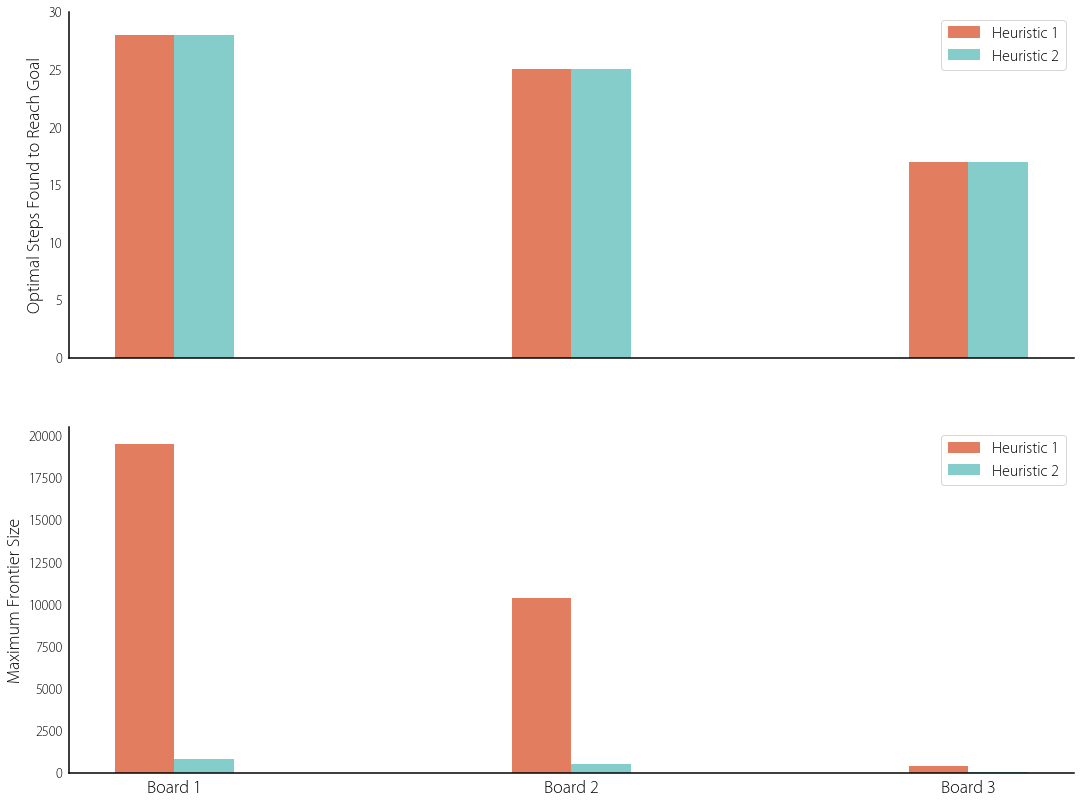

In [14]:
plot_result(results, heuristics)